# Deep Reinforcement Learning Project: Soft Actor-Critic (SAC) for HalfCheetah-v5
## **Author:** Timon Kuhl

This Jupyter Notebook implements a Soft Actor-Critic (SAC) agent to learn the HalfCheetah-v5 environment from OpenAI Gym. The project aims to demonstrate the application of reinforcement learning concepts, specifically policy-gradient and actor-critic methods, as discussed in the lecture "08 Policy-gradient and actor-critic RL".

### 1. Package Loading

In [7]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque
import random

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### 2. Model Definition

#### 2.2.1 Replay Buffer Implementation

In [8]:
class ReplayBuffer:
    """
    A simple replay buffer to store experiences for off-policy learning.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Adds an experience tuple to the buffer.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Samples a random batch of experiences from the buffer.
        """
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (
            np.array(state),
            np.array(action),
            np.array(reward),
            np.array(next_state),
            np.array(done)
        )

    def __len__(self):
        """
        Returns the current size of the buffer.
        """
        return len(self.buffer)

#### 2.2.2 Network Definitions


In [9]:

class Actor(nn.Module):
    """
    Policy network (Actor) for SAC. Outputs mean and log standard deviation for a Gaussian policy.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        log_std = self.log_std_head(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std

    def sample(self, state):
        """
        Samples an action from the policy distribution and computes its log probability.
        """
        mu, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mu, std)
        z = normal.rsample()
        action = torch.tanh(z)

        # Enforcing action bounds with tanh squashing
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

class Critic(nn.Module):
    """
    Q-value network (Critic) for SAC. Takes state and action as input, outputs a Q-value.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value

In [10]:
class SACAgent:
    """
    Soft Actor-Critic (SAC) Agent implementation.
    """
    def __init__(self, state_dim, action_dim,
                 hidden_dim=256,
                 learning_rate=3e-4,
                 gamma=0.99,
                 tau=0.005,
                 alpha=0.2, # Initial temperature parameter
                 target_entropy=None):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau # For soft update of target networks
        self.alpha = alpha # Temperature parameter

        # Actor Network
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)

        # Critic Networks (Two Q-networks)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate)

        # Target Critic Networks (Copies for stability)
        self.target_critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())

        # Automatic entropy tuning (alpha)
        if target_entropy is None:
            self.target_entropy = -float(action_dim)  
        else:
            self.target_entropy = target_entropy
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=learning_rate*0.1)

    def get_action(self, state):
        """
        Samples an action from the current policy for interaction with the environment.
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = self.actor.sample(state)
        return action.detach().cpu().numpy()[0]

    def update(self, replay_buffer, batch_size):
        """
        Performs a single training update step for the SAC agent.
        """
        if len(replay_buffer) < batch_size:
            return None, None, None 

        # Sample batch from replay buffer
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # --- Update Critic Networks (Q-functions) ---
        with torch.no_grad():
            next_action, log_prob_next_action = self.actor.sample(next_state)
            target_q1 = self.target_critic1(next_state, next_action)
            target_q2 = self.target_critic2(next_state, next_action)
            min_target_q = torch.min(target_q1, target_q2) - self.alpha * log_prob_next_action
            target_q_value = reward + (1 - done) * self.gamma * min_target_q

        current_q1 = self.critic1(state, action)
        current_q2 = self.critic2(state, action)

        loss_critic1 = F.mse_loss(current_q1, target_q_value)
        loss_critic2 = F.mse_loss(current_q2, target_q_value)

        self.critic1_optimizer.zero_grad()
        loss_critic1.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        loss_critic2.backward()
        self.critic2_optimizer.step()

        # --- Update Actor Network (Policy) ---
        new_action, log_prob_new_action = self.actor.sample(state)
        q1_new_action = self.critic1(state, new_action)
        q2_new_action = self.critic2(state, new_action)
        min_q_new_action = torch.min(q1_new_action, q2_new_action)

        actor_loss = (self.alpha * log_prob_new_action - min_q_new_action).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # --- Update Alpha (Temperature) ---
        alpha_loss = -(self.log_alpha * (log_prob_new_action + self.target_entropy).detach()).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        self.alpha = self.log_alpha.exp().item()

        # --- Soft Update of Target Critic Networks ---
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return loss_critic1.item(), actor_loss.item(), self.alpha

In [11]:
ENV_NAME = "HalfCheetah-v5"
MAX_EPISODES = 150 
MAX_STEPS_PER_EPISODE = 1000 
BATCH_SIZE = 256
REPLAY_BUFFER_CAPACITY = 1_000_000
LEARNING_RATE = 3e-4
GAMMA = 0.99
TAU = 0.005 
HIDDEN_DIM = 256

# Initialize environment
env = gym.make(ENV_NAME)
observation, info = env.reset(seed=0) 
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0] 

print(f"Environment: {ENV_NAME}")
print(f"State Dimension: {state_dim}")
print(f"Action Dimension: {action_dim}")
print(f"Max Action Value: {max_action}")

# Initialize replay buffer and agent
replay_buffer = ReplayBuffer(REPLAY_BUFFER_CAPACITY)
agent = SACAgent(state_dim, action_dim,
                 hidden_dim=HIDDEN_DIM,
                 learning_rate=LEARNING_RATE,
                 gamma=GAMMA,
                 tau=TAU)

# Training metrics
episode_rewards = []
actor_losses = []
critic_losses = []
alphas = []

Environment: HalfCheetah-v5
State Dimension: 17
Action Dimension: 6
Max Action Value: 1.0


### 3 Training Loop

In [12]:
print("Starting training...")
WARMUP_STEPS = 5000 
total_steps = 0 

for episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    steps = 0

    
    critic_loss = 0.0 
    actor_loss = 0.0
    alpha_val = agent.alpha 


    while not done and steps < MAX_STEPS_PER_EPISODE:
        if total_steps < WARMUP_STEPS:
            action = env.action_space.sample() # Take random action for warmup
        else:
            action = agent.get_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action * max_action)
        done = terminated or truncated

        replay_buffer.push(state, action, reward, next_state, done)

        if total_steps >= WARMUP_STEPS: # update after warmup
            temp_critic_loss, temp_actor_loss, temp_alpha_val = agent.update(replay_buffer, BATCH_SIZE)

            if temp_critic_loss is not None:
                critic_loss = temp_critic_loss
                actor_loss = temp_actor_loss
                alpha_val = temp_alpha_val

                critic_losses.append(critic_loss)
                actor_losses.append(actor_loss)
                alphas.append(alpha_val)

        state = next_state
        episode_reward += reward
        steps += 1
        total_steps += 1 

    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"""Episode {episode}/{MAX_EPISODES}   Reward: {episode_reward:.2f}   Avg 10 Episodes Reward: {avg_reward:.2f}   Buffer Size: {len(replay_buffer)}   Alpha: {agent.alpha:.4f}""")

env.close()
print("Training finished.")

Starting training...
Episode 10/150   Reward: -248.51   Avg 10 Episodes Reward: -266.98   Buffer Size: 10000   Alpha: 0.8609
Episode 20/150   Reward: -223.44   Avg 10 Episodes Reward: -138.05   Buffer Size: 20000   Alpha: 0.6387
Episode 30/150   Reward: -61.68   Avg 10 Episodes Reward: -149.27   Buffer Size: 30000   Alpha: 0.4735
Episode 40/150   Reward: -51.58   Avg 10 Episodes Reward: -26.49   Buffer Size: 40000   Alpha: 0.3509
Episode 50/150   Reward: 281.41   Avg 10 Episodes Reward: 42.58   Buffer Size: 50000   Alpha: 0.2601
Episode 60/150   Reward: 549.66   Avg 10 Episodes Reward: 325.28   Buffer Size: 60000   Alpha: 0.1930
Episode 70/150   Reward: 1337.68   Avg 10 Episodes Reward: 872.67   Buffer Size: 70000   Alpha: 0.1434
Episode 80/150   Reward: 582.45   Avg 10 Episodes Reward: 1448.18   Buffer Size: 80000   Alpha: 0.1072
Episode 90/150   Reward: 2810.33   Avg 10 Episodes Reward: 2170.15   Buffer Size: 90000   Alpha: 0.0807
Episode 100/150   Reward: 2891.35   Avg 10 Episodes R

Saving the model

In [13]:
import os

SAVE_DIR = "trained_sac_model"
os.makedirs(SAVE_DIR, exist_ok=True) 

actor_path = os.path.join(SAVE_DIR, "sac_actor.pth")
torch.save(agent.actor.state_dict(), actor_path)
print(f"Actor model saved to {actor_path}")

critic1_path = os.path.join(SAVE_DIR, "sac_critic1.pth")
critic2_path = os.path.join(SAVE_DIR, "sac_critic2.pth")
log_alpha_path = os.path.join(SAVE_DIR, "sac_log_alpha.pth")

torch.save(agent.critic1.state_dict(), critic1_path)
torch.save(agent.critic2.state_dict(), critic2_path)
torch.save(agent.log_alpha, log_alpha_path) 

print(f"Critic1 model saved to {critic1_path}")
print(f"Critic2 model saved to {critic2_path}")
print(f"Log_alpha tensor saved to {log_alpha_path}")


Actor model saved to trained_sac_model/sac_actor.pth
Critic1 model saved to trained_sac_model/sac_critic1.pth
Critic2 model saved to trained_sac_model/sac_critic2.pth
Log_alpha tensor saved to trained_sac_model/sac_log_alpha.pth


In [16]:
def load_agent(state_dim, action_dim, hidden_dim, path, device):
    """
    Loads the state dictionaries into new instances of the actor and critic networks.
    Returns a new SACAgent instance with loaded weights.
    """
    actor_path = os.path.join(path, "sac_actor.pth")
    critic1_path = os.path.join(path, "sac_critic1.pth")
    critic2_path = os.path.join(path, "sac_critic2.pth")
    alpha_path = os.path.join(path, "sac_log_alpha.pth")

    # Create new agent instance
    loaded_agent = SACAgent(state_dim, action_dim, hidden_dim=hidden_dim)

    # Load state dicts
    loaded_agent.actor.load_state_dict(torch.load(actor_path, map_location=device))
    loaded_agent.critic1.load_state_dict(torch.load(critic1_path, map_location=device))
    loaded_agent.critic2.load_state_dict(torch.load(critic2_path, map_location=device))
    loaded_agent.target_critic1.load_state_dict(loaded_agent.critic1.state_dict()) # Target critics also need to be updated
    loaded_agent.target_critic2.load_state_dict(loaded_agent.critic2.state_dict())

    # Load log_alpha
    loaded_log_alpha = torch.load(alpha_path, map_location=device)
    loaded_agent.log_alpha = loaded_log_alpha
    loaded_agent.alpha = loaded_log_alpha.exp().item()


    # Set networks to evaluation mode by default for loaded models
    loaded_agent.actor.eval()
    loaded_agent.critic1.eval()
    loaded_agent.critic2.eval()

    print(f"Agent models loaded from {path}")
    return loaded_agent

### 4. Evaluation


#### 4.1 Learning Curve

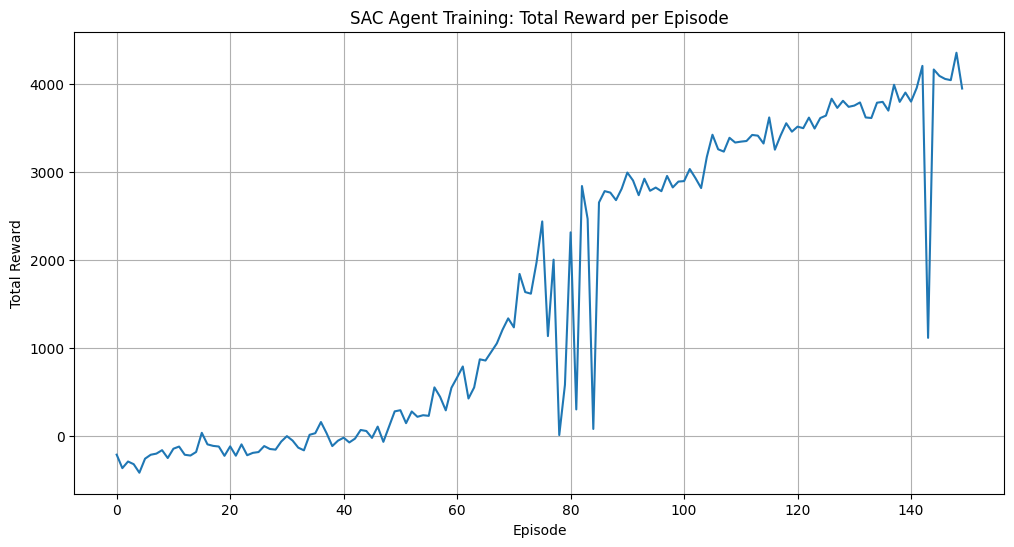

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SAC Agent Training: Total Reward per Episode")
plt.grid(True)
plt.show()

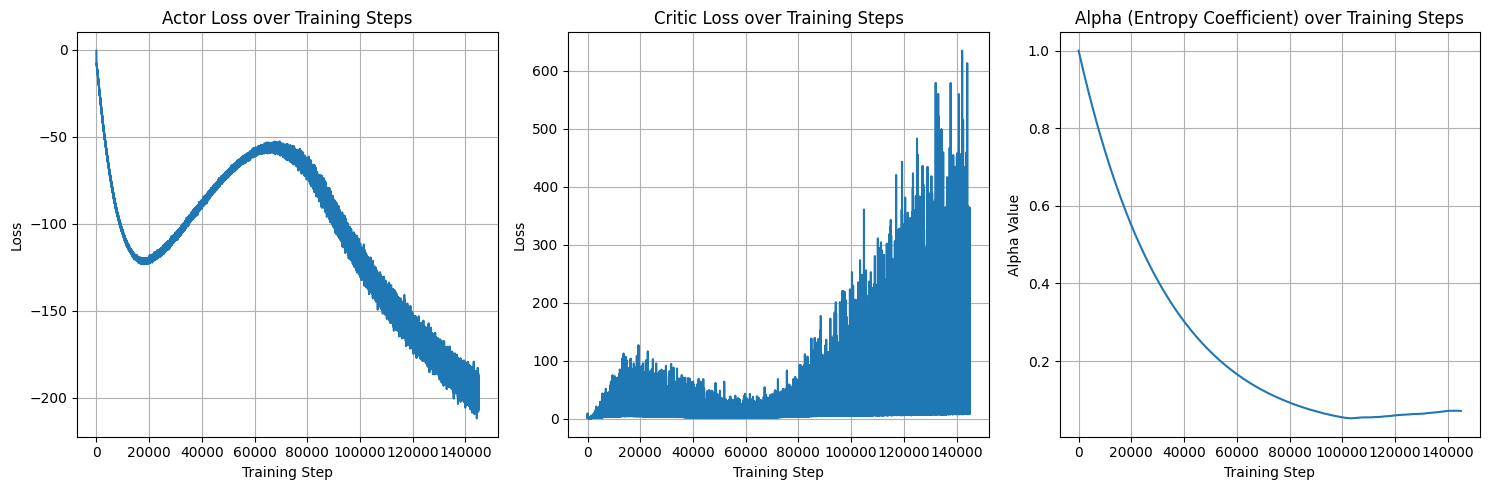

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(actor_losses)
plt.title("Actor Loss over Training Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(critic_losses)
plt.title("Critic Loss over Training Steps")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(alphas)
plt.title("Alpha (Entropy Coefficient) over Training Steps")
plt.xlabel("Training Step")
plt.ylabel("Alpha Value")
plt.grid(True)

plt.tight_layout()
plt.show()

#### 4.2 Visual Environment


Running 5 evaluation episodes with video recording...
Episode 1: Reward = 4172.56
Episode 2: Reward = 4169.48
Episode 3: Reward = 4201.12
Episode 4: Reward = 3986.57
Episode 5: Reward = 4109.17


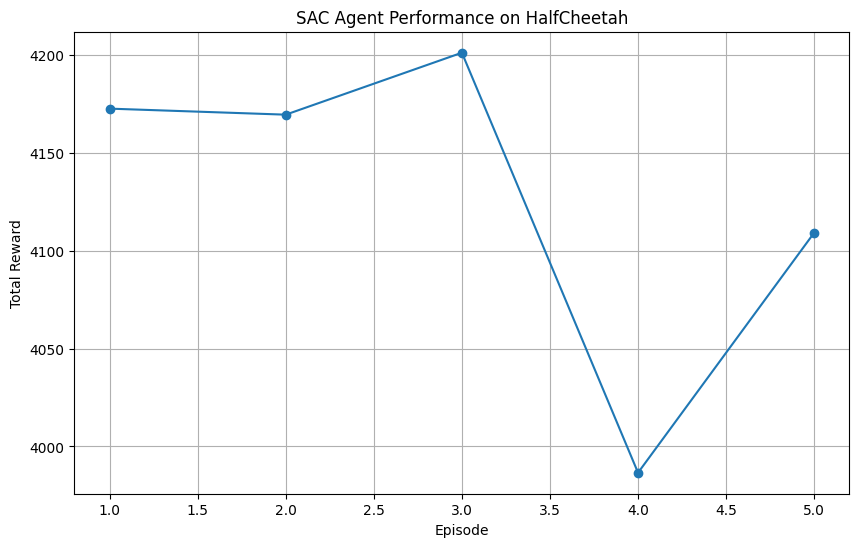


Average reward over 5 episodes: 4127.78
Standard deviation of rewards: 76.69
Videos saved to: halfcheetah_environment_videos


In [18]:
# create a video of the half cheetah environment
from gymnasium.wrappers import RecordVideo

env_name = "HalfCheetah-v5"


base_env = gym.make(env_name, render_mode='rgb_array') 
state_dim = base_env.observation_space.shape[0]
action_dim = base_env.action_space.shape[0]
hidden_dim = 256

# Path to your saved models
model_save_path = "trained_sac_model"

# Load the agent
if 'agent' not in locals():
    try:
        agent = load_agent(state_dim, action_dim, hidden_dim, model_save_path, device)
    except FileNotFoundError:
        print(f"Error: Model files not found in {model_save_path}.")
        print("Please ensure the directory exists and contains sac_actor.pth, sac_critic1.pth, sac_critic2.pth, and sac_log_alpha.pth.")
        exit()

# Define the folder for saving videos
video_folder = "halfcheetah_environment_videos"
os.makedirs(video_folder, exist_ok=True) 

# Wrap the environment with RecordVideo
env = RecordVideo(
    base_env,
    video_folder=video_folder,
    episode_trigger=lambda x: x % 1 == 0,
    name_prefix="halfcheetah_sac_run"
)


num_eval_episodes = 5
episode_rewards = []

print(f"\nRunning {num_eval_episodes} evaluation episodes with video recording...")

for episode in range(num_eval_episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    step_count = 0
    max_steps_per_episode = 1000

    while not done and not truncated and step_count < max_steps_per_episode:
        action = agent.get_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        state = next_state
        step_count += 1
        # No need for env.render() or time.sleep() here when using RecordVideo
        # The wrapper handles frame capturing internally.

    episode_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}")

env.close()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_eval_episodes + 1), episode_rewards, marker='o')
plt.title('SAC Agent Performance on HalfCheetah')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

print(f"\nAverage reward over {num_eval_episodes} episodes: {np.mean(episode_rewards):.2f}")
print(f"Standard deviation of rewards: {np.std(episode_rewards):.2f}")
print(f"Videos saved to: {video_folder}")